If you choose the Time Series option, you will be forecasting real estate prices of various zip codes using data from Zillow Research. For this project, you will be acting as a consultant for a fictional real-estate investment firm. The firm has asked you what seems like a simple question:

What are the top 5 best zip codes for us to invest in?

This may seem like a simple question at first glance, but there's more than a little ambiguity here that you'll have to think through in order to provide a solid recommendation. Should your recommendation be focused on profit margins only? What about risk? What sort of time horizon are you predicting against? Your recommendation will need to detail your rationale and answer any sort of lingering questions like these in order to demonstrate how you define "best".

The goal of this project is to have you complete a very common real-world task in regard to time series modeling. However, real world problems often come with a significant degree of ambiguity, which requires you to use your knowledge of statistics and data science to think critically about and answer. While the main task in this project is time series modeling, that isn't the overall goal -- it is important to understand that time series modeling is a tool in your toolbox, and the forecasts it provides you are what you'll use to answer important questions.

Evaluation
In addition to deciding which quantitative metric(s) you want to target (e.g. minimizing mean squared error), you need to start with a definition of "best investment". Consider additional metrics like risk vs. profitability, or ROI yield.

# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!

Metric: ROI (Return on Investment)

In [1]:
# import relevant packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import itertools

# statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

%matplotlib inline

# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [2]:
df=pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,14723.000000,14723.000000,14723.000000,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,...,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04
mean,81075.010052,48222.348706,7362.000000,1.182991e+05,1.184190e+05,1.185374e+05,1.186531e+05,1.187803e+05,1.189275e+05,1.191205e+05,...,2.733354e+05,2.748658e+05,2.764646e+05,2.780332e+05,2.795209e+05,2.810953e+05,2.826571e+05,2.843687e+05,2.865114e+05,2.880399e+05
std,31934.118525,29359.325439,4250.308342,8.600251e+04,8.615567e+04,8.630923e+04,8.646795e+04,8.665094e+04,8.687208e+04,8.715185e+04,...,3.603984e+05,3.614678e+05,3.627563e+05,3.644610e+05,3.656003e+05,3.670454e+05,3.695727e+05,3.717739e+05,3.724612e+05,3.720544e+05
min,58196.000000,1001.000000,1.000000,1.130000e+04,1.150000e+04,1.160000e+04,1.180000e+04,1.180000e+04,1.200000e+04,1.210000e+04,...,1.440000e+04,1.450000e+04,1.470000e+04,1.480000e+04,1.450000e+04,1.430000e+04,1.410000e+04,1.390000e+04,1.380000e+04,1.380000e+04
25%,67174.500000,22101.500000,3681.500000,6.880000e+04,6.890000e+04,6.910000e+04,6.920000e+04,6.937500e+04,6.950000e+04,6.960000e+04,...,1.269000e+05,1.275000e+05,1.282000e+05,1.287000e+05,1.292500e+05,1.299000e+05,1.306000e+05,1.310500e+05,1.319500e+05,1.324000e+05
50%,78007.000000,46106.000000,7362.000000,9.950000e+04,9.950000e+04,9.970000e+04,9.970000e+04,9.980000e+04,9.990000e+04,9.995000e+04,...,1.884000e+05,1.896000e+05,1.905000e+05,1.914000e+05,1.925000e+05,1.934000e+05,1.941000e+05,1.950000e+05,1.967000e+05,1.981000e+05
75%,90920.500000,75205.500000,11042.500000,1.432000e+05,1.433000e+05,1.432250e+05,1.432250e+05,1.435000e+05,1.437000e+05,1.439000e+05,...,3.050000e+05,3.066500e+05,3.085000e+05,3.098000e+05,3.117000e+05,3.134000e+05,3.151000e+05,3.168500e+05,3.188500e+05,3.211000e+05
max,753844.000000,99901.000000,14723.000000,3.676700e+06,3.704200e+06,3.729600e+06,3.754600e+06,3.781800e+06,3.813500e+06,3.849600e+06,...,1.888990e+07,1.870350e+07,1.860530e+07,1.856940e+07,1.842880e+07,1.830710e+07,1.836590e+07,1.853040e+07,1.833770e+07,1.789490e+07


In [4]:
# Filter for NYC
nyc_df = df[df['City'] == 'New York']

In [5]:
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114 entries, 6 to 11037
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 243.1+ KB


# Step 2: Data Preprocessing

In [6]:
# Convert dates to datetime objects
def get_datetimes(df):
    """
    Takes a dataframe:
    Returns only those column names that can be converted into datetime objects
    as datetime objects.
    """
    date_columns = [col for col in df.columns if pd.to_datetime(col, format='%Y-%m', errors='coerce') is not pd.NaT]
    return pd.to_datetime(date_columns, format='%Y-%m')

# Run the function
datetime_columns = get_datetimes(nyc_df)
print(datetime_columns)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)


# Step 3: EDA and Visualization

# Step 4: Reshape from Wide to Long Format

In [7]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [8]:
ts=melt_data(nyc_df)

C:\Users\hrcoh\AppData\Local\Temp\ipykernel_17316\1276467365.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)


In [9]:
# Check if stationary data using the Dickey-Fuller Test

def display_df (dftest):
    '''
    Display the ouput from a Dickey-Fuller test in a more readable format
    '''
    
    dfoutput=pd.Series(
    dftest[0:4],
    index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    display(dfoutput)

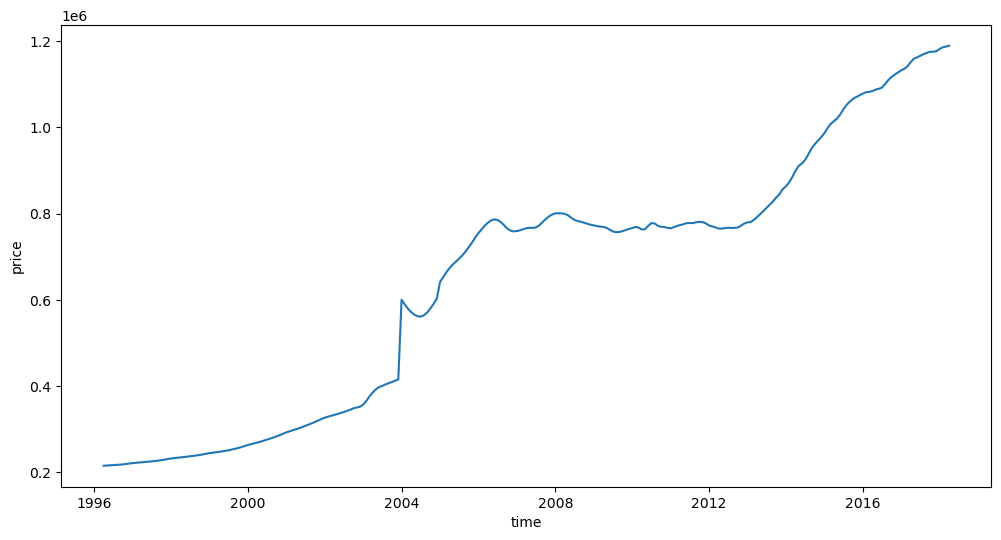

<Figure size 640x480 with 0 Axes>

In [10]:
fig=plt.figure(figsize=(12,6))
plt.plot(ts)
plt.xlabel('time')
plt.ylabel('price')
plt.show()
plt.gcf().autofmt_xdate()

In [11]:
# Dickey-Fuller
dftest=adfuller(ts)

In [12]:
dftest

(0.5733344856328106,
 0.9869395921319222,
 0,
 264,
 {'1%': -3.455365238788105,
  '5%': -2.8725510317187024,
  '10%': -2.5726375763314966},
 5388.9560265894825)

In [13]:
display_df(dftest)

Test Statistic                   0.573334
p-value                          0.986940
#Lags Used                       0.000000
Number of Observations Used    264.000000
Critical Value (1%)             -3.455365
Critical Value (5%)             -2.872551
Critical Value (10%)            -2.572638
dtype: float64

Fail to reject null since p-value > 0.05 so we can conclude this data is not stationary.

In [14]:
rolmean=ts.rolling(window=6,center=False).mean()
rolstd=ts.rolling(window=6,center=False).std()

In [15]:
rolmean.head(10)

,value
time,
1996-04-01,NaN
1996-05-01,NaN
1996-06-01,NaN
1996-07-01,NaN
1996-08-01,NaN
1996-09-01,215995.032051
1996-10-01,216523.237179
1996-11-01,217124.198718
1996-12-01,217825.000000


In [16]:
rolmean.tail

<bound method NDFrame.tail of                    value
time                    
1996-04-01           NaN
1996-05-01           NaN
1996-06-01           NaN
1996-07-01           NaN
1996-08-01           NaN
...                  ...
2017-12-01  1.172805e+06
2018-01-01  1.175426e+06
2018-02-01  1.178074e+06
2018-03-01  1.180506e+06
2018-04-01  1.182867e+06

[265 rows x 1 columns]>

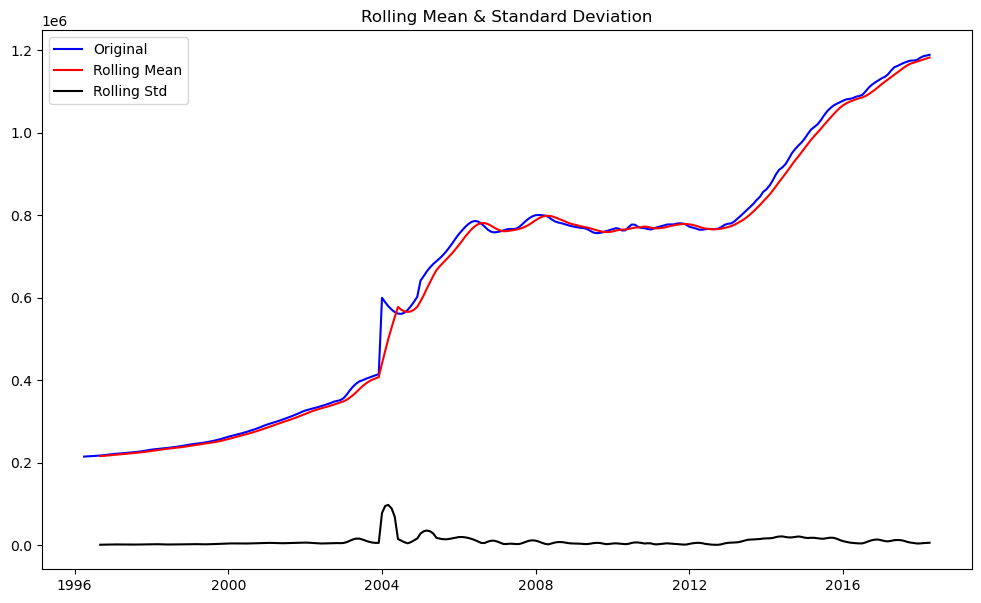

In [17]:
fig=plt.figure(figsize=(12,7))
orig=plt.plot(ts,color='blue',label='Original')
mean=plt.plot(rolmean,color='red',label='Rolling Mean')
std=plt.plot(rolstd,color='black',label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [18]:
# Use the rolling mean to subtract from time series
# Use the square root to transform

data_transform=pd.Series(np.sqrt(ts['value'].values),index=ts.index)

In [19]:
data_transform.head()

time
1996-04-01    463.485955
1996-05-01    463.932812
1996-06-01    464.433070
1996-07-01    464.958642
1996-08-01    465.532160
dtype: float64

In [20]:
# Rolling mean with a window of 4

rolmean= data_transform.rolling(window=4, center=False).mean()

In [21]:
data_minus_rolmean=data_transform-rolmean

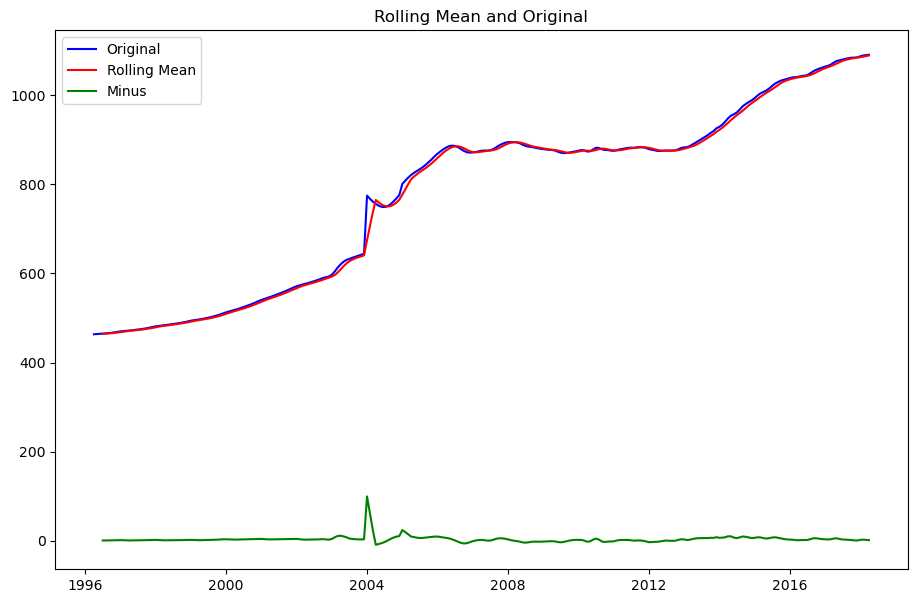

In [22]:
fig=plt.figure(figsize=(11,7))
orig=plt.plot(data_transform,color='blue',label='Original')
mean=plt.plot(rolmean,color='red',label='Rolling Mean')
minus=plt.plot(data_minus_rolmean,color='green',label='Minus')
plt.legend(loc='best')
plt.title('Rolling Mean and Original')
plt.show(block=False)

In [23]:
# Check for Nans
data_minus_rolmean.isnull().sum()

3

In [24]:
# Drop the NaN values from the timeseries calculated above

data_minus_rolmean.dropna(inplace=True)

In [25]:
# Check if stationary now using Dickey-Fuller again

dftest=adfuller(data_minus_rolmean)
display_df(dftest)

Test Statistic                -6.391080e+00
p-value                        2.105190e-08
#Lags Used                     3.000000e+00
Number of Observations Used    2.580000e+02
Critical Value (1%)           -3.455953e+00
Critical Value (5%)           -2.872809e+00
Critical Value (10%)          -2.572775e+00
dtype: float64

Now we have stationary data since the p-value is small.

In [26]:
# Differencing to convert non-stationary series into stationary (this instead of the manual method above)

diff=data_transform.diff().dropna()

In [27]:
dftest=adfuller(diff)
display_df(dftest)

Test Statistic                -1.572489e+01
p-value                        1.310424e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.630000e+02
Critical Value (1%)           -3.455461e+00
Critical Value (5%)           -2.872593e+00
Critical Value (10%)          -2.572660e+00
dtype: float64

<Axes: xlabel='time'>

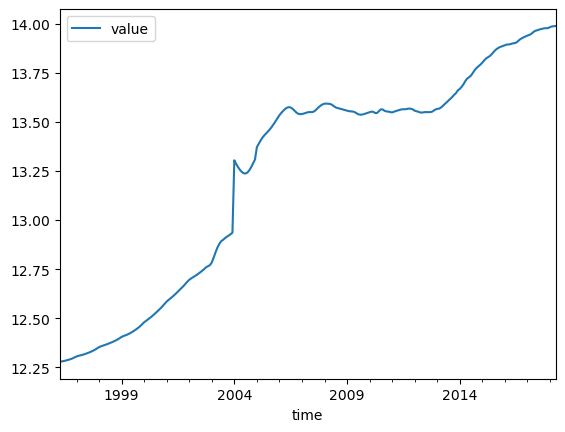

In [28]:
# log transform to get rid of heteroscendasticity
ts_log=np.log(ts)
ts_log.plot()

In [29]:
# Decompose

decomposition = seasonal_decompose(np.log(ts), model='additive', period=12)

In [30]:
trend=decomposition.trend

In [31]:
seasonal=decomposition.seasonal

In [32]:
residual = decomposition.resid.dropna()

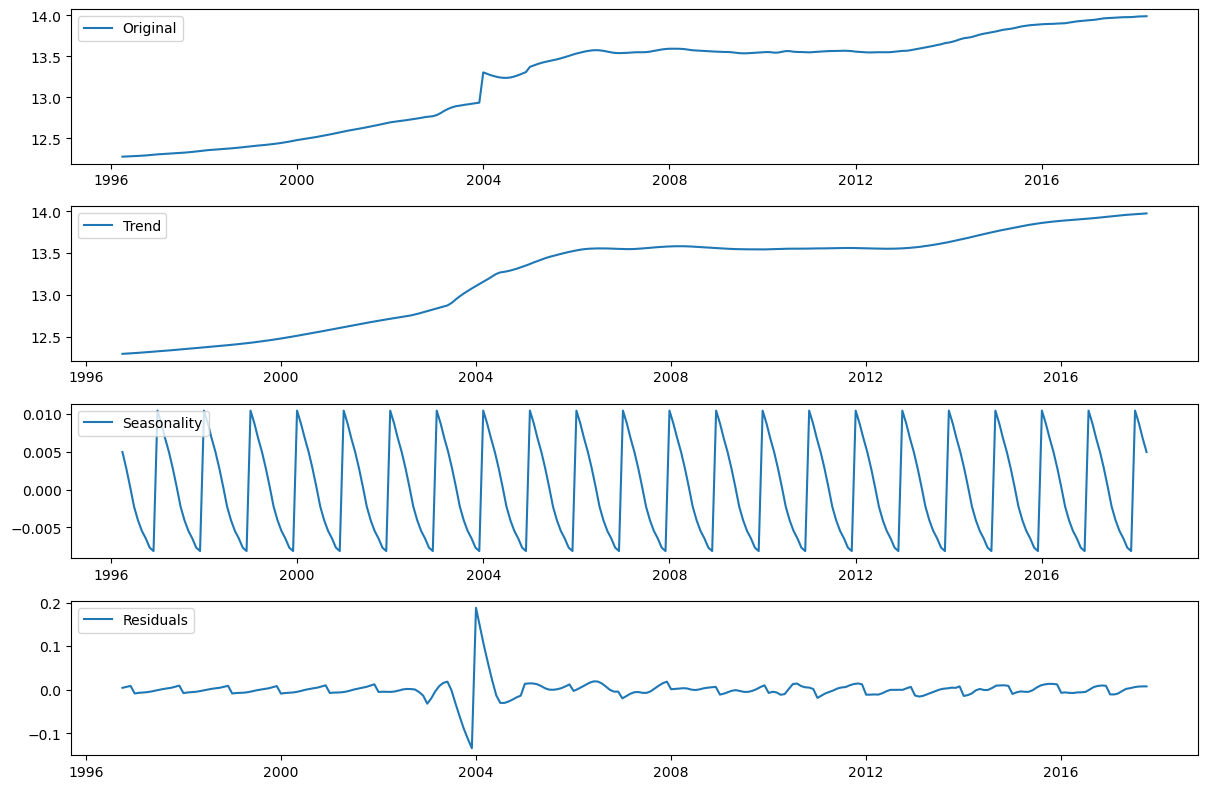

In [33]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(ts),label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

In [34]:
ts_log_decompose=residual

In [35]:
# Dickey-Fuller on residuals

dftest=adfuller(ts_log_decompose)
display_df(dftest)

Test Statistic                -9.392871e+00
p-value                        6.490082e-16
#Lags Used                     5.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64

Now we can use residuals for modelling

# Step 5: ARIMA Modeling

In [36]:
# find the index which allows us to split off 20% of the data
cutoff = round(ts_log_decompose.shape[0]*0.8)
cutoff

202

In [38]:
# Define train and test sets according to the index found above
train = ts_log_decompose[:cutoff]

test = ts_log_decompose[cutoff:]

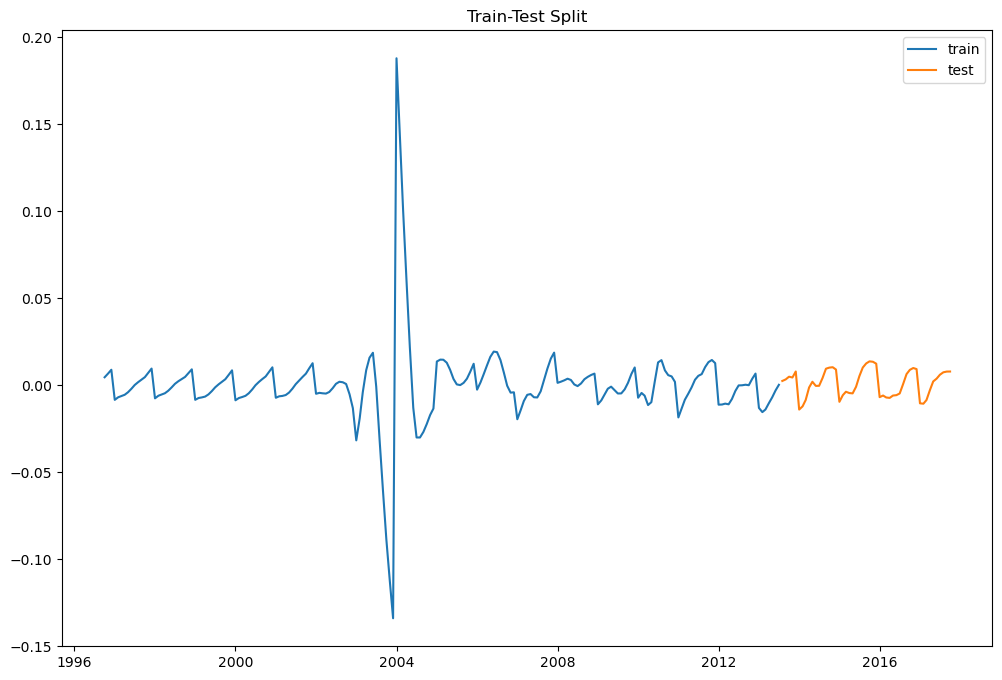

In [39]:
# Plot it!
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [40]:
# Time Series Split

split=TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print (f'Train index: {train_ind}')
    print (f'Test index: {val_ind}')

Train index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
Test index: [37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69]
Train index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
Test index: [ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102]
Train index: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  9

## Baseline

In [42]:
# we can perform this with the shift operator
# The prediction for the next day is the original series shifted to the future by one day.
naive = train.shift(1)
naive

time
1996-10-01         NaN
1996-11-01    0.004520
1996-12-01    0.006639
1997-01-01    0.008841
1997-02-01   -0.008462
                ...   
2013-03-01   -0.015506
2013-04-01   -0.014019
2013-05-01   -0.010380
2013-06-01   -0.007046
2013-07-01   -0.003031
Name: resid, Length: 202, dtype: float64

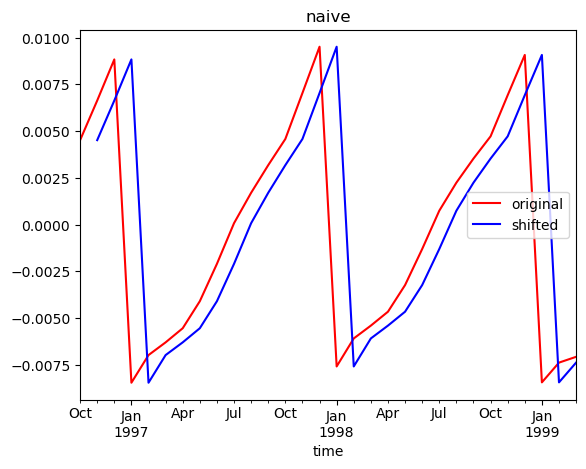

In [43]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [44]:
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

0.024830158653407645

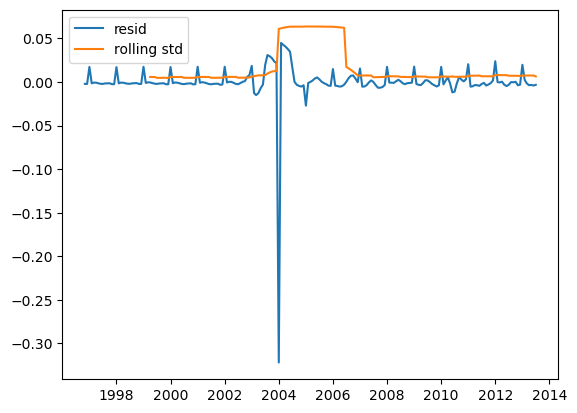

In [45]:
fig, ax = plt.subplots()
residuals = naive[1:] - train[1:]
ax.plot(residuals.index, residuals, label='resid')
ax.plot(residuals.index, residuals.rolling(30).std(), label='rolling std')
ax.legend();

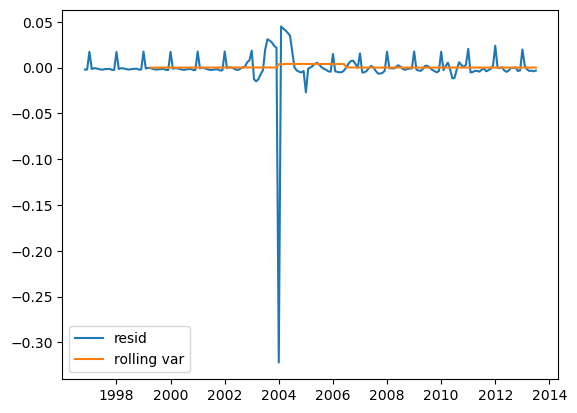

In [46]:
fig, ax = plt.subplots()
ax.plot(residuals.index, residuals, label='resid')
ax.plot(residuals.index, residuals.rolling(30).var(), label='rolling var')
ax.legend();

In [51]:
arma = ARIMA(train, order=(2, 1, 2)).fit()

C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible startin

In [54]:
print(arma.aic)

-956.5479895535913


In [55]:
def find_rmse(model, train_data=train):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [57]:
print(find_rmse(arma))

0.021703954198201564


In [58]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

NameError: name 'train_with_ind' is not defined

In [60]:
def find_rmse_test(model, test_data=test):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return np.sqrt(mean_squared_error(test_data, y_hat))

In [61]:
print(find_rmse_test(arma))

0.007761925685747199


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


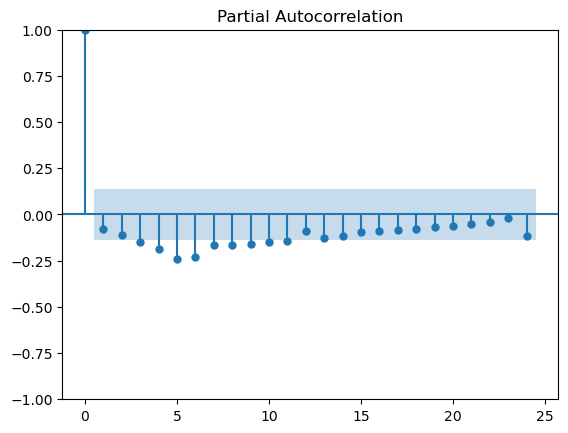

In [62]:
plot_pacf(train.diff().dropna());

In [63]:
df = pd.DataFrame(train)
df.columns = ['lag_0']
df['lag_1'] = train.shift()
df.head()

,lag_0,lag_1
time,,
1996-10-01,0.004520,NaN
1996-11-01,0.006639,0.004520
1996-12-01,0.008841,0.006639
1997-01-01,-0.008462,0.008841
1997-02-01,-0.006982,-0.008462


In [64]:
gamma_1 = sum(((df['lag_0'][1:]-df['lag_0'][1:].mean()) *\
               (df['lag_1'].dropna()-df['lag_1'].dropna().mean())))/(len(df['lag_1'])-1)
gamma_1

0.00033647521453719067

C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible startin

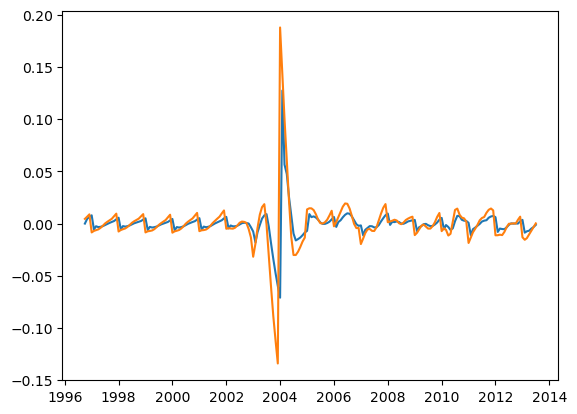

In [65]:
aa_model = ARIMA(train, order=(1, 1, 2)).fit()
y_hat_train = aa_model.predict(typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_train)
ax.plot(train);

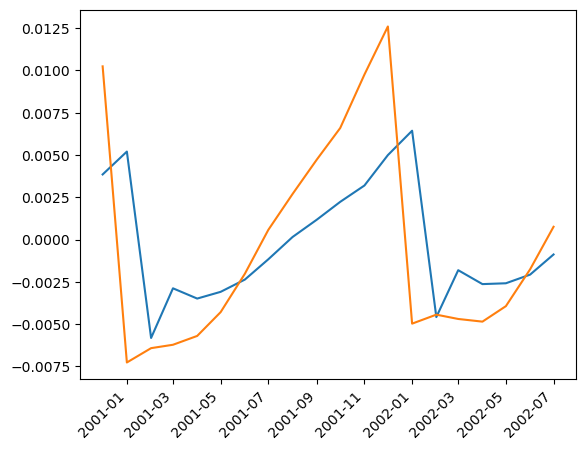

In [66]:
# Let's zoom in:

fig, ax = plt.subplots()
ax.plot(y_hat_train[50:70])
ax.plot(train[50:70])
plt.xticks(rotation = 45, ha='right');

In [67]:
aa_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                  202
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 485.456
Date:                Tue, 25 Feb 2025   AIC                           -962.911
Time:                        08:23:00   BIC                           -949.698
Sample:                    10-01-1996   HQIC                          -957.564
                         - 07-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3742      0.086      4.331      0.000       0.205       0.543
ma.L1         -0.7726      0.572     -1.352      0.176      -1.893       0.348
ma.L2         -0.2258      0.181     -1.249      0.212      -0.580       0.128
sigma2         0.0005      0.000      1.759      0.079   -5.24e-05       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             91043.37
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.51   Skew:                             8.22
Prob(H) (two-sided):                  0.10   Kurtosis:                       105.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Testing

C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


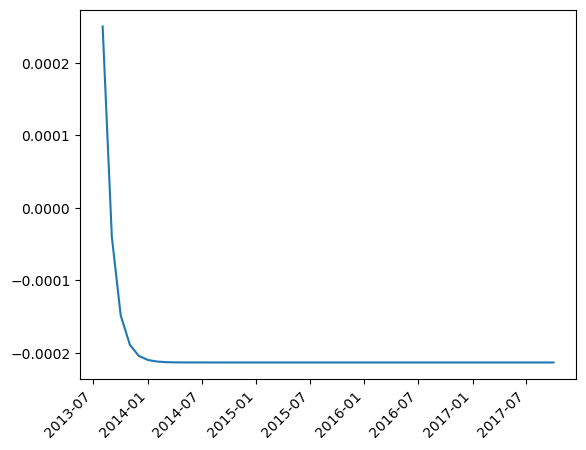

In [69]:
y_hat_test = aa_model.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_test)
plt.xticks(rotation = 45, ha='right');

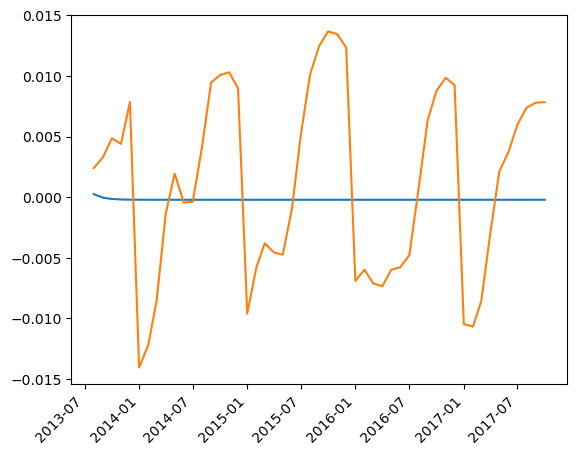

In [70]:
fig, ax = plt.subplots()
ax.plot(y_hat_test)
ax.plot(test)
plt.xticks(rotation = 45, ha='right');

In [71]:
np.sqrt(mean_squared_error(test, y_hat_test))

0.007753042977552788

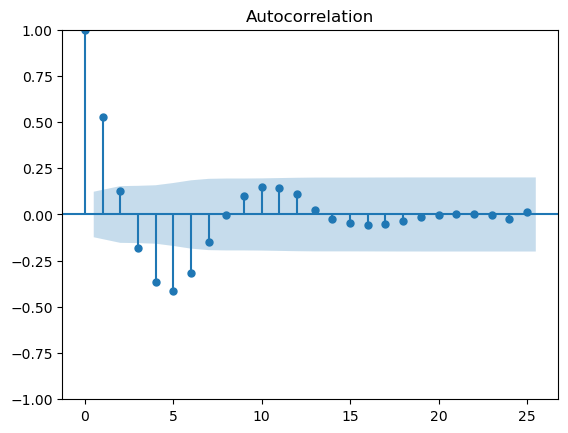

In [72]:
plot_acf(ts_log_decompose);

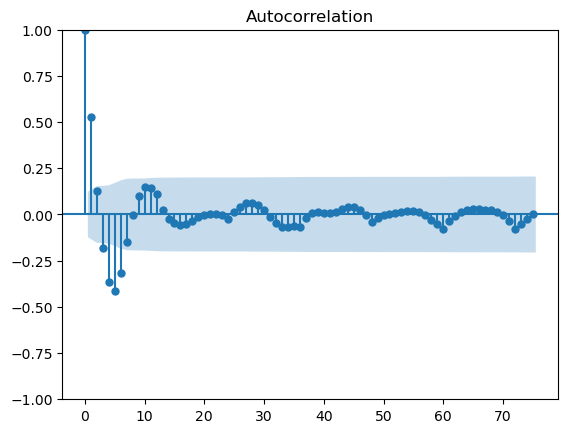

In [74]:
plot_acf(ts_log_decompose, lags=75);

## SARIMA

In [75]:
p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 1, 0, 52)
SARIMAX: (0, 1, 0) x (1, 1, 1, 52)
SARIMAX: (0, 1, 1) x (0, 1, 0, 52)
SARIMAX: (0, 1, 1) x (0, 1, 1, 52)
SARIMAX: (0, 1, 1) x (1, 1, 0, 52)
SARIMAX: (0, 1, 1) x (1, 1, 1, 52)
SARIMAX: (1, 1, 0) x (0, 1, 0, 52)
SARIMAX: (1, 1, 0) x (0, 1, 1, 52)
SARIMAX: (1, 1, 0) x (1, 1, 0, 52)
SARIMAX: (1, 1, 0) x (1, 1, 1, 52)
SARIMAX: (1, 1, 1) x (0, 1, 0, 52)
SARIMAX: (1, 1, 1) x (0, 1, 1, 52)
SARIMAX: (1, 1, 1) x (1, 1, 0, 52)
SARIMAX: (1, 1, 1) x (1, 1, 1, 52)


In [76]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('Oops!')
            continue

C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 0)x(0, 1, 0, 52) - AIC:-526.7561316489607


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(0, 1, 1, 52) - AIC:-457.1223038449775


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 1, 0, 52) - AIC:-430.8590350000441


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(1, 1, 1, 52) - AIC:-462.8706929548058


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(0, 1, 0, 52) - AIC:-521.6333154325282


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(0, 1, 1, 52) - AIC:-449.57849397331006


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(1, 1, 0, 52) - AIC:-429.40811481060075


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(1, 1, 1, 52) - AIC:-455.37049862812484


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(0, 1, 0, 52) - AIC:-525.8249856432265


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(0, 1, 1, 52) - AIC:-455.2512163479261


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(1, 1, 0, 52) - AIC:-423.8176994810136


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(1, 1, 1, 52) - AIC:-461.05420706020834


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(0, 1, 0, 52) - AIC:-555.7062252920387


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Oops!


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Oops!


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Oops!


In [77]:
sari_mod =SARIMAX(train,
                  order=(1, 1, 1),
                  seasonal_order=(0, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

In [78]:
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      order=(1, 1, 1),
                     seasonal_order=(0, 1, 1, 52),
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

NameError: name 'train_with_ind' is not defined

In [79]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

NameError: name 'sari_mod' is not defined

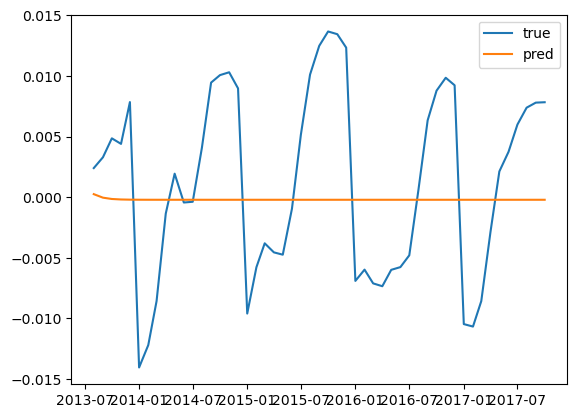

In [80]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

In [ ]:
np.sqrt(mean_squared_error(test, y_hat_test))

## Forecast

In [81]:
sari_mod = SARIMAX(ts_weekly,
                  order=(1, 1, 1),
                  seasonal_order=(0, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

NameError: name 'ts_weekly' is not defined

In [82]:
forecast = sari_mod.forecast(steps=52)

NameError: name 'sari_mod' is not defined

NameError: name 'ts_weekly' is not defined

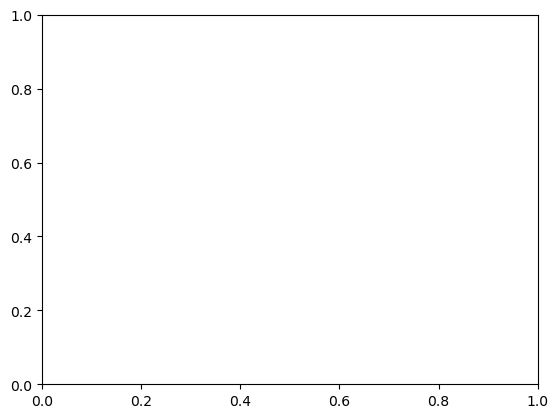

In [83]:
fig, ax = plt.subplots()
ax.plot(ts_weekly, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Chicago Gun Crime Predictions\n One Year out')

plt.legend();

# Step 6: Interpreting Results